## Projeto 1 - Métodos de Busca utilizando o jogo Pacman

O problema é composto por um agente (Pacman) e um labirinto. O labirinto é um grid de $n$ linhas e $m$ colunas indexadas de $0$ a $n-1$ e de $0$ a $m-1$ respectivamente, como mostra a Figura 1 abaixo. Áreas em preto representam paredes, áreas em azul representam posições atravessáveis e as bolinhas brancas representam comidas que devem ser coletadas pelo agente. Ladrilhos em cinza representam fantasmas (posições não atravessáveis que devem ser evitadas pelo agente).

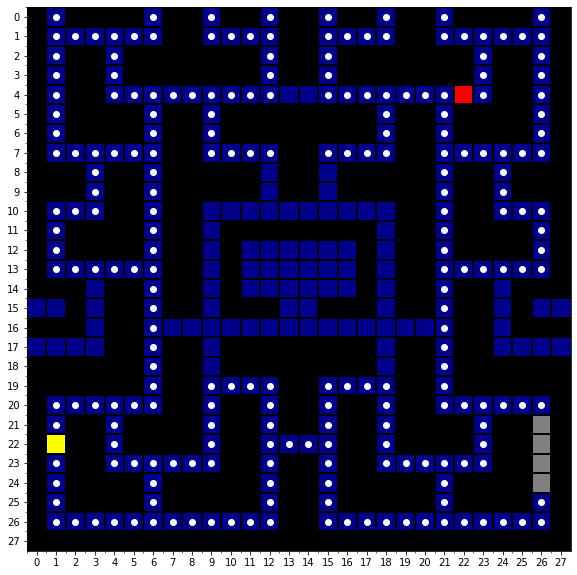

### Objetivo:

O objetivo é fazer o agente (pacman) chegar a um estado final, isto é, chegar a uma posição objetivo (x, y), coletando o maior número possível de comidas durante o caminho. Na Figura 1, os ladrilhos em amarelo e vermelho representam a posição inicial e final do agente, respectivamente.


### Labirintos:

Os labirintos utilizados no problema foram criados a partir de modificações (junções) dos labirintos disponíveis em https://github.com/shaunlebron/pacman-mazegen.

### Modelagem do problema:

Um estado é representado por uma dupla $(i, j)$ que indica a posição do pacman, i.e, $i$ indica a linha e $j$ a coluna do labirinto. A armazenagem do labirinto foi feita por meio uma lista de objetos de uma classe Posição. A classe Posição possui as coordenadas $i, j$ do estado e um boolean que é verdadeiro caso a posição seja uma comida ou falso, caso contrário. Apenas as posições atravessáveis e as posições dos fantasmas são armazenadas, ou seja, não são armazenadas as posições que são paredes.

##### Ações: 

Existem quatro ações possíveis para o agente: ir para cima, para baixo, para esquerda e para direita. Não é possível ir para uma posição através de diagonais. O agente pode atravessar de um lado do labirinto para o outro lado através de túneis. Um túnel é representado por duas posições atravessáveis de fronteira de mesma linha ou coluna. As posições $(0, 15)$ e $(27, 15)$ representam um túnel na Figura 1.

O custo de cada ação é definida por: 
$1$,  se o estado resultante pela ação for uma comida
$1000$, caso contrário

Desse modo o agente possui como objetivo encontrar um caminho até a posição objetivo com custo mínimo.

### Heurísticas utilizadas:


#### Distância Manhattan
Dado dois pontos, $p_1$ em $(x_1, y_1)$ e $p_2$ em $(x_2, y_2)$ a distância Manhattan (ou Norma $L1$) é calculada como:
$$D_{manh} = |x_1 - x_2| + |y_1 - y_2|$$

Admissibilidade:
Dada as ações do nosso problema, o Pacman só realiza movimentos paralelos aos eixos $x$ e $y$, dessa forma o custo total do caminho entre dois pontos sempre será maior ou igual à distância Manhattan entre esses pontos. Note que isso não seria verdadeiro se o Pacman andasse em diagonais. Temos então que a distância Manhattan é uma heurística admissível.

Monotonicidade:
Dado um nó A, com $h(A) = x$. Para os quatro possíveis nós vizinhos de A, dado o cálculo da distância Manhattan, o $h(n)$ desses vizinhos pode ser $x - 1$ ou $x + 1$. Se o custo para ir do nó A ao seus vizinhos for maior que um, temos que a heurística é monotônica.

#### Distância Wavefront
A distância Wavefront é a distância de um campo potencial a partir de uma posição. A construção desse campo é baseado em uma BFS, ou seja, para um nó A, cujo $h(A) = x$, e cujo nó pai tem $h(A_{pai}) = x -1$, os vizinhos do nó $A$ (note que é preciso ter uma lista de nós visitados, pois o nó filho não pode retornar para o estado do nó pai) possuem $h(A_{filho}) = x + 1$.
Esse algoritmo também é conhecido com expansão térmica.

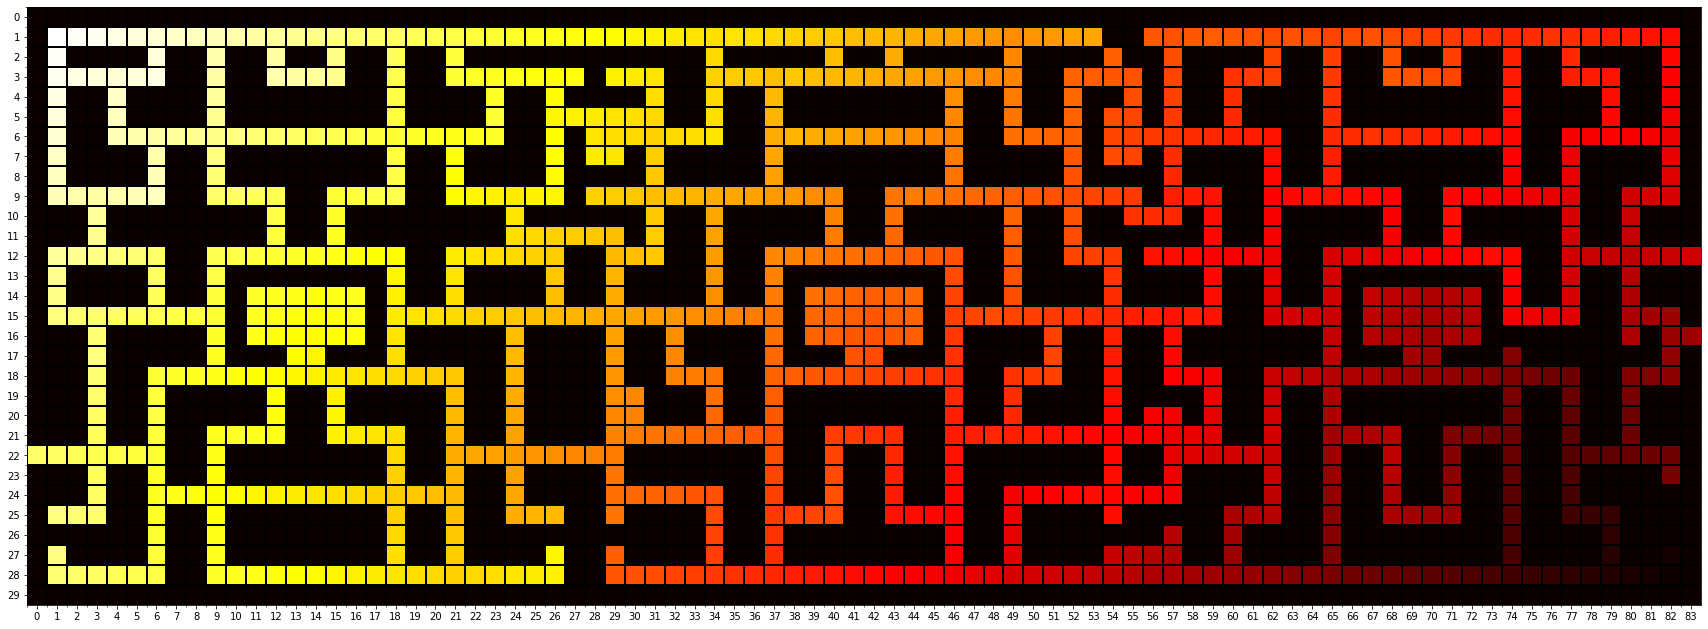

Nesta imagem podemos ver um exemplo de um labirinto criado utilizando a distância Wavefront. Quanto mais distante do objetivo, mais claro (frio) é o valor.

Para construí-lo, começamos com o ponto final, esse cujo h(n) = 0. Para cada um de seus nós filhos, seus h(n) serão o h(n) do nó pai somado de 1, adicionamos esses nós filhos em uma pilha e seguimos iterativamente até esgotarmos a pilha. Dessa forma, o valor do campo de cada nó nada mais é que a sua profundidade em relação à raíz (posição do goal).

Admissibilidade:
Dada as ações do nosso problema, o Pacman só realiza movimentos paralelos aos eixos x e y, dessa forma o custo total do caminho entre 2 pontos sempre será maior ou igual à distância Wavefront, pois por definição a distância wavefront sempre será o menor valor a ser percorrido de um nó até sua raíz.

Monotonicidade:
Dado um nó A, com h(A) = x. Para os 4 possíveis nós vizinhos de A, dado o cálculo da distância Wavefront, o h(n) desses vizinhos pode ser x - 1 ou x + 1. Se o custo para ir do nó A ao seus vizinhos for maior que 1, temos que a heurística é monotônica.


#### Evasão de Fantasmas
Para esta heurística, a proximidade do agente em relação aos fantasmas é considerada. O intuito é evitar áreas do labirinto que contém tais adversários ,pois em um cenário real do jogo, o contato dos fantasmas com o agente causa o término da partida sem que a meta seja alcançada. Para esta heurística, é utilizada a distância Euclidiana. Dado dois pontos p_1 (x_1, y_1) e p_2 (x_2, y_2):
$$D_{eucl}(p_2,p_1) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$
Considerando a presença de $n$ fantasmas no labirinto, o cálculo do indicador de proximidade de um fantasma $i, 0 \leq i < n$, em relação ao agente é:
$$
 G_{avoidance}(p_{pacman}, p_{ghost i}) = 
  \begin{cases} 
   \dfrac{C}{D_{eucl}(p_{pacman}, P_{ghost i})} & \text{if } D_{eucl}(p_{pacman}, P_{ghost i}) < R \\
   0       & \text{otherwise }
  \end{cases}
$$
Sendo $C$ o parâmetro de custo de aproximação do fantasma, e $R$ o parâmetro de faixa de aproximação do fantasma. Logo, enquanto o fantasma está mais distante que o valor $R$ de um fantasma, o custo de aproximação do respectivo elemento é 0. Quando o agente entra nesta faixa de aproximação, o custo é proporcional à distância do fantasma em relação ao custo $C$. Quanto mais próximo do fantasma, maior é a influência do custo.
A heurística é calculada por:
$$h_{ghost avoidance}(p_{pacman}) = D_{eucl}(p_{pacman}, p_{goal}) + \sum_{i = 0}^{n}G_{avoidance}(p_{pacman}, p_{ghost i})$$
Em outras palavras, leva em consideração a proximidade do pacman ao goal e em relação a todos os fantasmas.

Admissibilidade:
Dada as ações do nosso problema, o Pacman só realiza movimentos paralelos aos eixos x e y, dessa forma o custo total do caminho entre 2 pontos sempre será maior ou igual à distância Euclidiana entre esses pontos. Temos então que a distância Euclidiana é uma heurística admissível.
Monotonicidade: Dado um nó A, com h(A) = x. Para os 4 possíveis nós vizinhos de A, o $h(n)$ desses nós até a meta pode ser $x - m + G$ ou $x + m + G$, com $0 < m \leq 1$ sendo a contribuição da distância até a meta, e $G \geq 0$ a contribuição da proximidade dos fantasmas. Se o custo para ir do nó A ao seus vizinhos for maior que 1, temos que a heurística é monotônica.


### Implementação:

Todos os métodos de busca utilizados foram adaptações dos métodos da biblioteca AIMA disponível em https://github.com/aimacode/aima-python


### Buscas implementadas:

- Sem informação:
    - BFS: Nó raiz é expandido primeiro, seguido dos sucessores deste nó, seguido dos sucessores dos sucessores do nó raiz, e assim por diante. É completo, mas não garante que é ótimo, pois os caminhos não tem o mesmo custo. Todos os nós permanecem na memória.
    - DFS: Sempre expande o nó mais pronfundo na árvore de busca, implementado utilizando uma pilha. Não é completo se uma ramificação não tem fim, e não é ótimo. Uma vez que uma ramificação é explorada completamente, pode ser removida da memória.

- Informadas:
	- Busca Gulosa: Esta busca tenta seguir pelo nó mais próximo da meta, assumindo que isso levará para a solução mais rápida. A função objetivo leva em consideração apenas a heurística aplicada. O método não é ótimo, mas é completo, pois mantém controle dos estados repetidos. 
	- A*: Avalia não apenas o custo para chegar até o objetivo do nó (a heurística), mas também o custo para chegar até o nó analisado. Se a heurística for admissível e monotônica, o método é completo e ótimo. 

- Locais:
	- Hill Climbing: Este método se utiliza apenas da informação do estado atual, e se move para os vizinhos imediatos desse estado. A função objetivo leva em consideração apenas a heurística aplicada. A meta é encontrar o melhor estado (no nosso caso, o mínimo possível para a heurística). Como considera apenas a informação do nó atual, finalizará a execução ao encontrar um mínimo local, sem necessariamente chegar ao objetivo. Não é completo, nem ótimo. Utiliza pouca memória, por não armazenar os nós explorados.
	- Simulated annealing: Esse método é semelhante ao Hill Climbing, porém ao invés de sempre selecionar um melhor estado, o simulated annealing permite que ocasionalmente estados piores sejam escolhidos, de forma a evitar mínimos locais. Quanto mais iterações passam, menos chances existem de ser selecionado um estado pior. Assim, no início da execução o algoritmo permite uma melhor exploração dos estados para buscar o mínimo global.
    
Todas as buscas implementadas (exceto das buscas locais) armazenam os nós que foram visitados, isto é, só passam por cada nó uma vez.

### Testes realizados:

Para a realização dos testes, foram utilizados labirintos de quatro tamanhos  e configurações diferentes:

- Tiny Maze: 30 x 28
- Small Maze: 30 x 84
- Medium Maze: 60 x 112
- Big Maze: 90 x 140

Para cada algoritmo e para cada um dos labirintos foram realizadas três execuções variando posição inicial do agente, posição objetivo e posição dos fantantas. 

#### Métricas coletadas:

Para cada execução, foram coletadas os seguintes dados:

- Tempo de execução
- Número máximo de nós mantidos na memória ao mesmo tempo (tamanho da maior fila durante execução)
- Número de nós expandidos
- Número de nós do tipo comida expandidos
- Número de nós no caminho 
- Número de nós no caminho expandido

Além disso, foram criados gráficos referentes ao caminhos encontrados por cada uma das buscas em cada uma das execuções.

### Resultados:

Os dados e os resultados de todos os testes realizados estão disponíveis em uma planilha que pode ser acessada por meio deste link https://docs.google.com/spreadsheets/d/1nf5nsZ5R_v15ccnkRu17dY-VKT9dF8f_NV3H7ozTv2o/edit?usp=sharing.
 Nesse relatório, para melhor visualização, apresentaremos os resultados baseados na média entre cada execução de mesmo tamanho de labirinto. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# importa o arquivo e guarda em um dataframe do Pandas
df = pd.read_csv( 'results.csv', sep=',', index_col=None) 
n_alg = 12 #numero de algoritmos
n = 3 * n_alg #numero de testes
df.insert(0,'Maze',"")
df['Maze'] = (df.index/(n)).astype('int32')
df['Custo Caminho'] = 1000*(df['Número de nós no caminho'] - df['Número de nós comida no caminho']) + df['Número de nós comida no caminho']

In [2]:
df["Maze"].replace({0: "Tiny", 1: "Small", 2:"Medium", 3:"Big"}, inplace=True)

## Algoritmos que não encontraram solução:

In [3]:
df.loc[df['Goal'] == 0].iloc[:, 0:2]

,Maze,Busca
8,Tiny,Hill-Climbing - Manhattan
9,Tiny,Hill-Climbing - Ghost Avoidance Euclidean
20,Tiny,Hill-Climbing - Manhattan
21,Tiny,Hill-Climbing - Ghost Avoidance Euclidean
33,Tiny,Hill-Climbing - Ghost Avoidance Euclidean
44,Small,Hill-Climbing - Manhattan
45,Small,Hill-Climbing - Ghost Avoidance Euclidean
47,Small,Simulated Annealing - Shockwave
56,Small,Hill-Climbing - Manhattan
57,Small,Hill-Climbing - Ghost Avoidance Euclidean


In [4]:
df.drop(df[df.Goal == 0].index, inplace=True)
del df['Goal']

tiny = df.loc[df['Maze'] == "Tiny"]
small = df.loc[df['Maze'] == "Small"]
medium = df.loc[df['Maze'] == "Medium"]
big = df.loc[df['Maze'] == "Big"]

## Tiny Maze

### Tempo e Memória

In [5]:
tiny = tiny.groupby("Busca").mean().round(2)
tiny.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Máximo de nós simultâneos na memória
Busca,,
Hill-Climbing - Shockwave,0.01,1.67
Greedy Search - Shockwave Heuristic,0.02,15.33
Greedy Search - Manhattan,0.03,17.00
A* Search - Manhattan,0.05,23.33
A* Search - Shockwave Heuristic,0.05,22.00
A* Search - Ghost Avoidance Euclidean,0.06,20.67
Hill-Climbing - Manhattan,0.06,2.00
DFS,0.07,29.67
BFS,0.10,18.33


### Nós Expandidos

In [6]:
tiny.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,
A* Search - Manhattan,109.67,107.33,46.33,45.67,712.33
A* Search - Shockwave Heuristic,104.33,101.67,46.33,45.67,712.33
A* Search - Ghost Avoidance Euclidean,116.67,112.67,49.67,49.00,715.67
BFS,281.33,203.67,37.00,33.00,4033.00
Hill-Climbing - Shockwave,24.33,19.33,25.00,19.67,5353.00
Greedy Search - Shockwave Heuristic,36.00,28.67,37.00,29.33,7696.00
Hill-Climbing - Manhattan,40.00,28.00,41.00,29.00,12029.00
Greedy Search - Manhattan,59.67,42.33,53.00,38.33,14705.00
Greedy Search - Ghost Avoidance Euclidean,156.33,118.33,57.00,40.67,16374.00


## Small Maze

### Tempo e Memória

In [7]:
small = small.groupby("Busca").mean().round(2)
small.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Máximo de nós simultâneos na memória
Busca,,
Greedy Search - Shockwave Heuristic,0.10,34.67
Hill-Climbing - Shockwave,0.10,2.00
Greedy Search - Manhattan,0.14,31.33
Greedy Search - Ghost Avoidance Euclidean,0.43,41.00
A* Search - Manhattan,0.50,48.00
A* Search - Shockwave Heuristic,0.55,46.33
A* Search - Ghost Avoidance Euclidean,0.58,61.67
DFS,0.62,104.33
BFS,0.78,22.33


### Nós expandidos

In [8]:
small.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,
A* Search - Manhattan,537.67,505.00,110.67,109.67,1109.67
A* Search - Shockwave Heuristic,508.67,478.00,110.67,109.67,1109.67
A* Search - Ghost Avoidance Euclidean,673.67,640.67,146.00,145.00,1145.00
Greedy Search - Manhattan,129.33,98.33,106.67,83.67,23083.67
BFS,958.00,722.33,94.67,65.67,29065.67
Greedy Search - Shockwave Heuristic,93.67,62.00,94.67,63.00,31729.67
Hill-Climbing - Shockwave,93.67,61.33,94.67,62.33,32395.67
Greedy Search - Ghost Avoidance Euclidean,513.33,377.33,149.33,102.33,47102.33
DFS,711.33,532.00,308.67,227.67,81227.67


## Medium Maze

### Tempo e Memória

In [9]:
medium = medium.groupby("Busca").mean().round(2)
medium.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Máximo de nós simultâneos na memória
Busca,,
Greedy Search - Shockwave Heuristic,0.19,45.33
Hill-Climbing - Shockwave,0.26,2.00
Greedy Search - Manhattan,0.34,50.33
Greedy Search - Ghost Avoidance Euclidean,2.57,73.33
DFS,2.79,232.67
Simulated Annealing - Shockwave,3.14,1.00
BFS,3.21,47.33
A* Search - Manhattan,4.76,134.67
A* Search - Ghost Avoidance Euclidean,5.10,152.67


### Nós expandidos

In [10]:
medium.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,
A* Search - Manhattan,2194.33,1825.67,155.33,149.00,6482.33
A* Search - Shockwave Heuristic,2260.33,1895.00,155.33,149.00,6482.33
A* Search - Ghost Avoidance Euclidean,2396.67,1986.67,213.33,207.00,6540.33
Hill-Climbing - Shockwave,95.00,76.00,96.00,76.67,19410.00
Greedy Search - Manhattan,163.00,115.67,118.67,92.67,26092.67
Greedy Search - Shockwave Heuristic,68.33,40.67,69.33,41.33,28041.33
BFS,1531.33,1151.33,69.33,41.00,28374.33
Greedy Search - Ghost Avoidance Euclidean,1220.67,893.00,95.33,52.33,43052.33
Simulated Annealing - Shockwave,1487.00,1368.67,555.33,461.00,94794.33


## Big Maze

### Tempo e Memória

In [11]:
big = big.groupby("Busca").mean().round(2)
big.sort_values(by=['Tempo']).iloc[:, 0:2]

,Tempo,Máximo de nós simultâneos na memória
Busca,,
Greedy Search - Shockwave Heuristic,0.69,71.67
Hill-Climbing - Shockwave,0.70,2.00
Greedy Search - Manhattan,4.54,95.00
DFS,11.98,614.33
Greedy Search - Ghost Avoidance Euclidean,14.92,180.00
A* Search - Ghost Avoidance Euclidean,15.72,246.67
BFS,16.03,73.67
A* Search - Manhattan,17.06,256.67
A* Search - Shockwave Heuristic,19.65,268.33


### Nós expandidos

In [12]:
big.sort_values(by=['Custo Caminho']).iloc[:, 2:]

,Número de nós expandidos,Número de nós comida expandidos,Número de nós no caminho,Número de nós comida no caminho,Custo Caminho
Busca,,,,,
A* Search - Manhattan,3828.33,3226.33,203.00,199.00,4199.00
A* Search - Shockwave Heuristic,3800.67,3212.33,203.00,199.00,4199.00
A* Search - Ghost Avoidance Euclidean,3696.33,3001.67,265.00,261.00,4261.00
BFS,3961.00,3058.67,153.00,112.00,41112.00
Hill-Climbing - Shockwave,152.00,108.33,153.00,109.33,43776.00
Greedy Search - Shockwave Heuristic,152.00,104.67,153.00,105.67,47439.00
Greedy Search - Manhattan,1089.00,815.00,265.67,172.67,93172.67
Greedy Search - Ghost Avoidance Euclidean,3645.33,2774.00,400.33,300.33,100300.33
DFS,3008.67,2324.33,1097.67,849.67,248849.67


In [13]:
def make_plot(feature):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(big.index, big[feature], label="Big", marker='P')
    ax.scatter(medium.index, medium[feature], label="Medium", marker='X')
    ax.scatter(small.index, small[feature], label="Small", marker='D')
    ax.scatter(tiny.index, tiny[feature], label="Tiny", marker='o')
    ax.legend()
    plt.ylabel(feature)
    plt.xticks(rotation=80)
    plt.show()

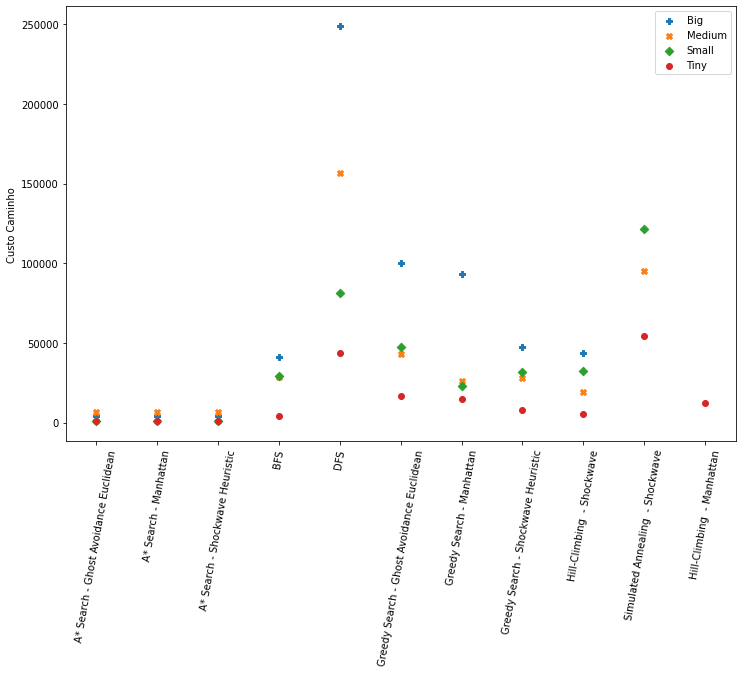

In [14]:
make_plot("Custo Caminho")

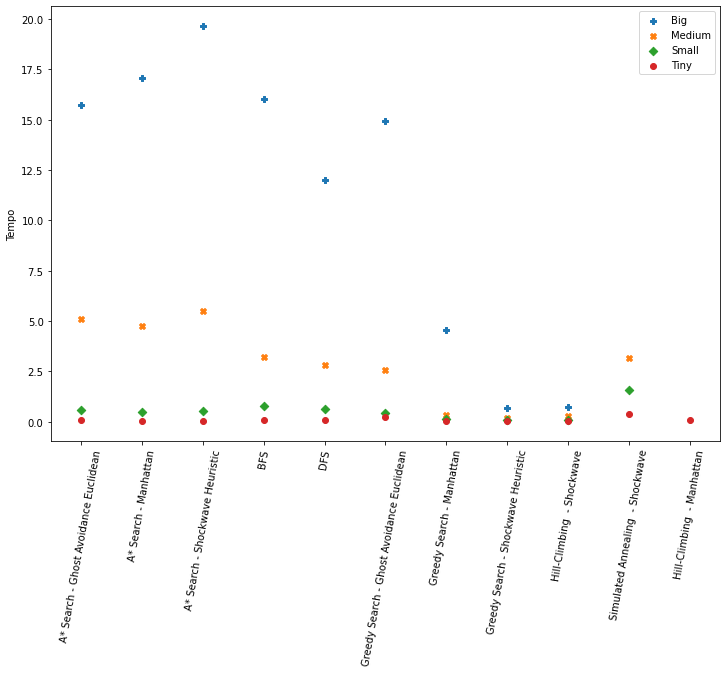

In [15]:
make_plot('Tempo')

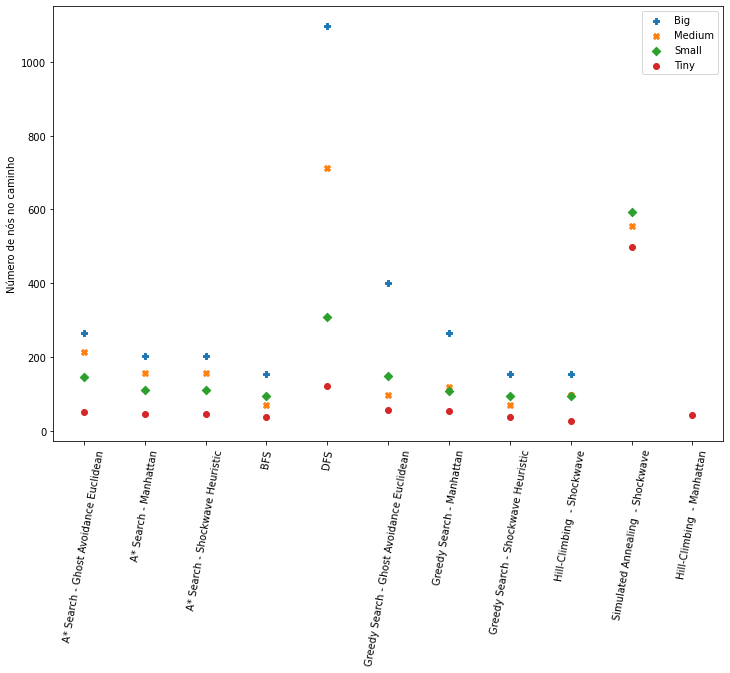

In [16]:
make_plot('Número de nós no caminho')

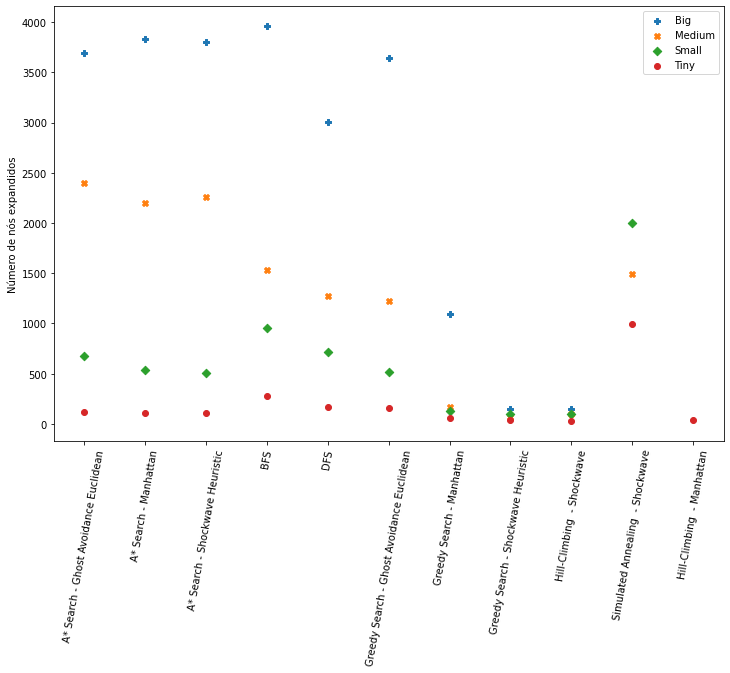

In [17]:
make_plot('Número de nós expandidos')

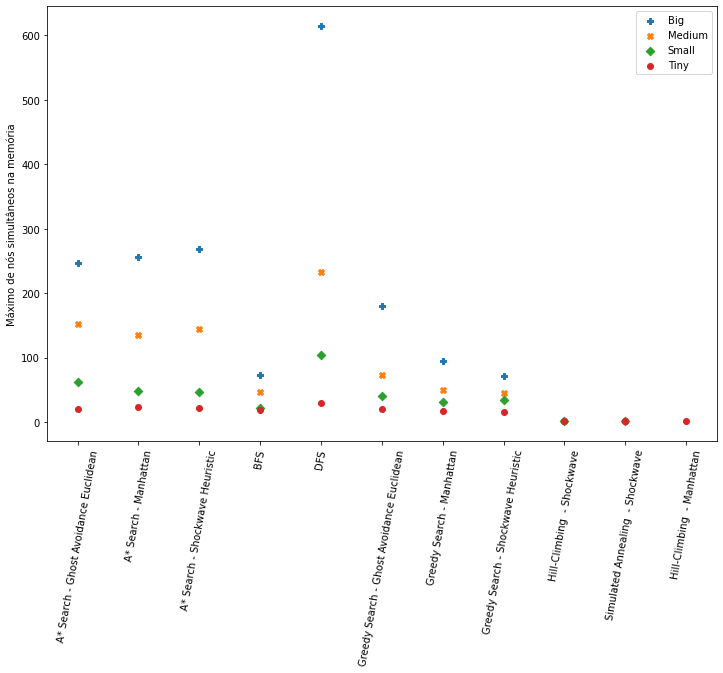

In [18]:
make_plot('Máximo de nós simultâneos na memória')